# importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Setting repeating plotting parameters

In [3]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (13,9)
plt.rcParams['font.size'] = 20
warnings.filterwarnings('ignore')


# Importing dataset

In [5]:
binary_data = pd.read_csv('archive/detect_dataset.csv')

binary_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Output (S)  12001 non-null  int64  
 1   Ia          12001 non-null  float64
 2   Ib          12001 non-null  float64
 3   Ic          12001 non-null  float64
 4   Va          12001 non-null  float64
 5   Vb          12001 non-null  float64
 6   Vc          12001 non-null  float64
 7   Unnamed: 7  0 non-null      float64
 8   Unnamed: 8  0 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [6]:
binary_data.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN


# Checking for null values

In [11]:
any(binary_data.isna().sum() > 0)


True

In [8]:
binary_data.drop(binary_data.iloc[:,[7,8]], axis=1, inplace=True)


In [9]:
binary_data.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050


# Data correlation

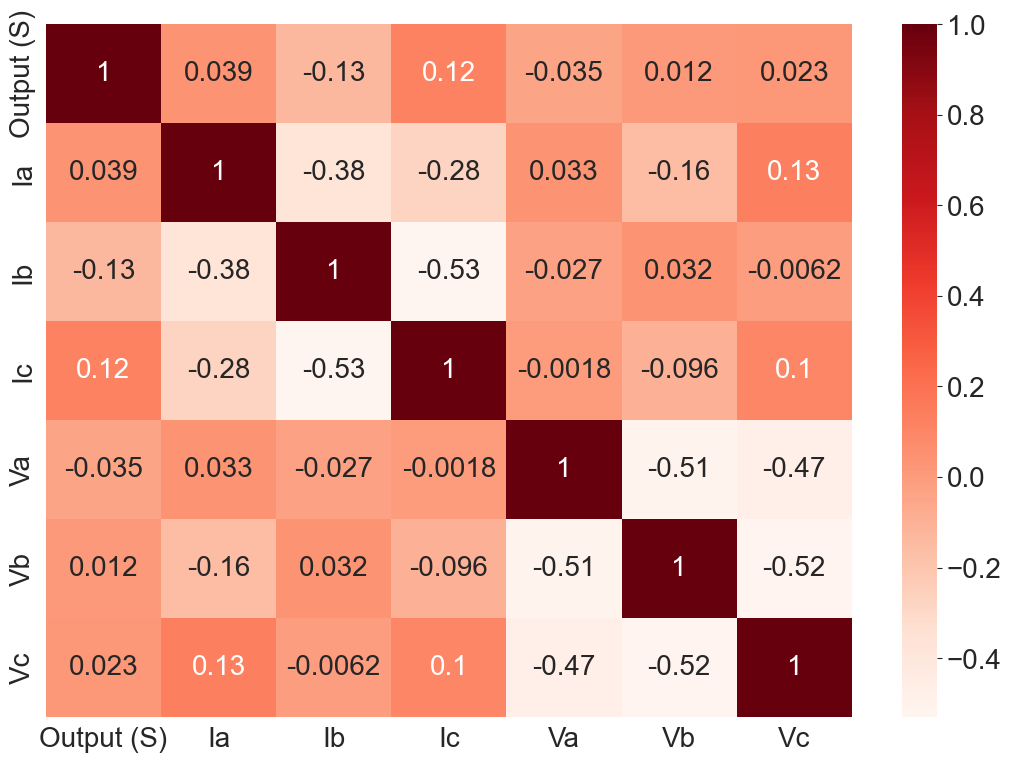

In [10]:
sns.heatmap(binary_data.corr(), annot=True, cmap='Reds')
plt.show()

# Investigating the relation between voltage and current in each phase of the transmission line

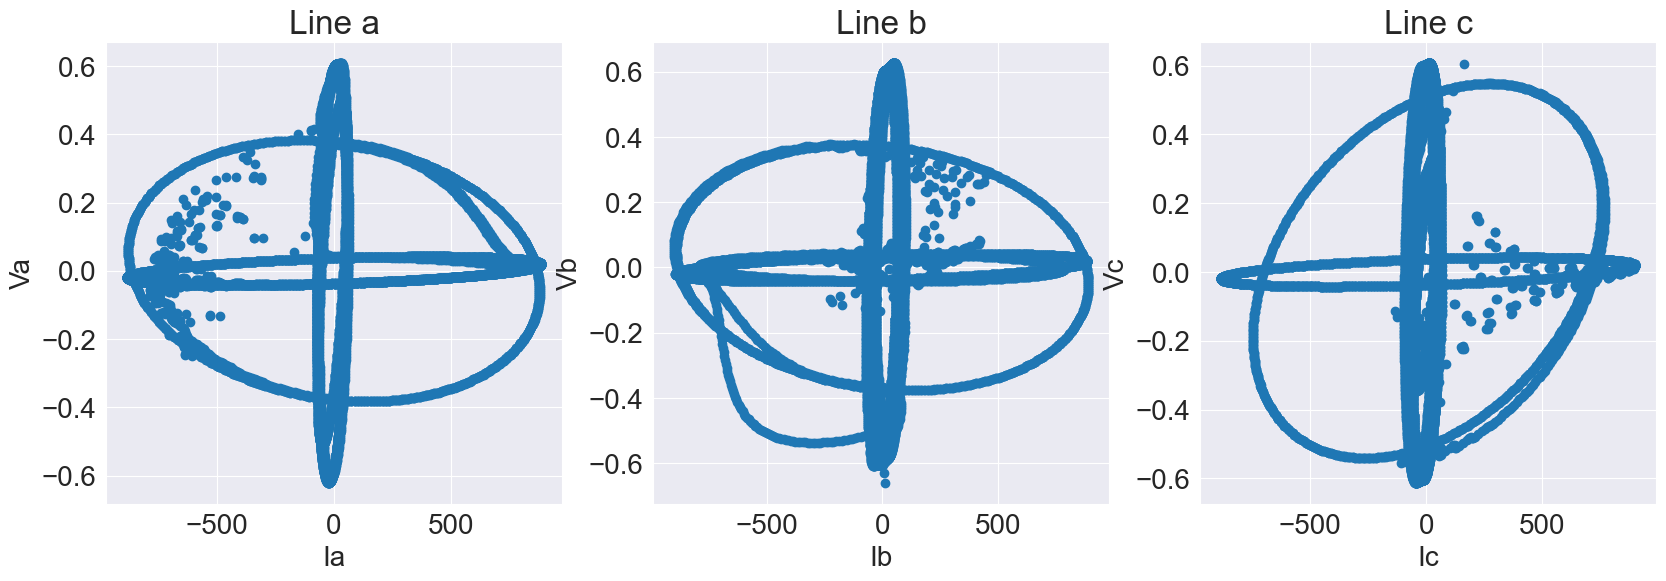

In [21]:
plt.figure(figsize=(20,6))

a1 = plt.subplot2grid((1,3),(0,0))
a1.scatter(binary_data['Ia'], binary_data['Va'])
a1.set_title('Line a')
a1.set_xlabel('Ia')
a1.set_ylabel('Va')

a2 = plt.subplot2grid((1,3),(0,1))
a2.scatter(binary_data['Ib'], binary_data['Vb'])
a2.set_title('Line b')
a2.set_xlabel('Ib')
a2.set_ylabel('Vb')

a3 = plt.subplot2grid((1,3),(0,2))
a3.scatter(binary_data['Ic'], binary_data['Vc'])
a3.set_title('Line c')
a3.set_xlabel('Ic')
a3.set_ylabel('Vc')

plt.show()


# Investigating  data imbalance

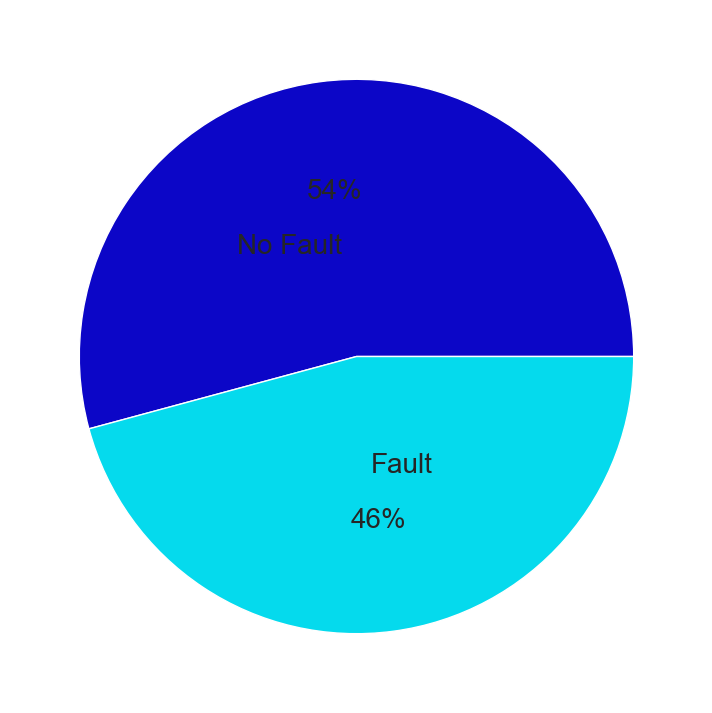

In [22]:
plt.pie(x=binary_data['Output (S)'].value_counts(), labels=['No Fault', 'Fault'],
        explode = [0, 0], autopct= '%1.f%%', labeldistance=0.4,
       colors=['#0c06c7', '#05daed'])
plt.show()


# Investigating data distributions

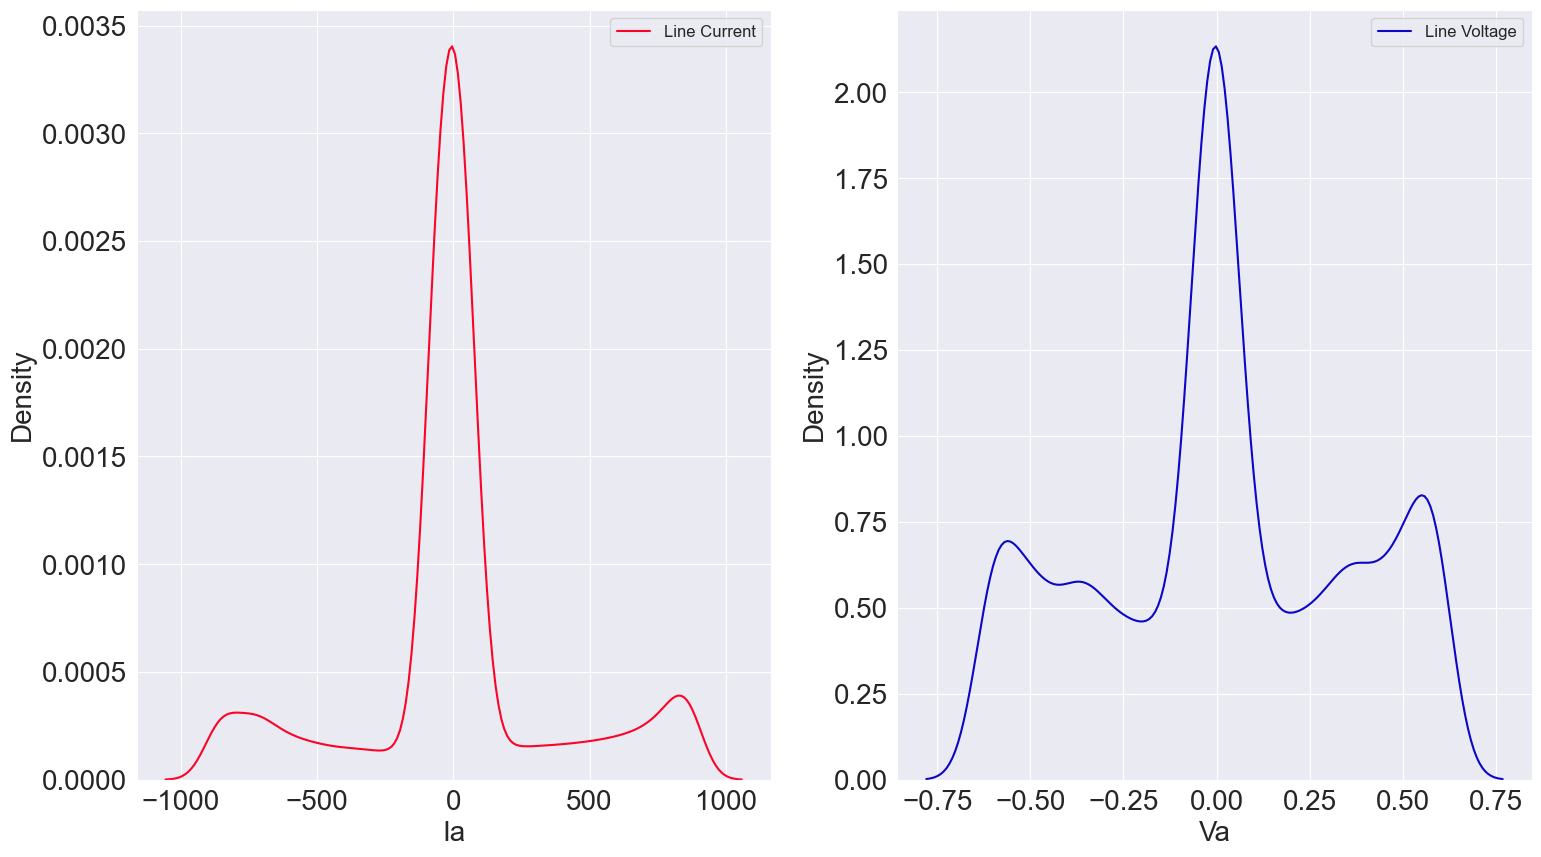

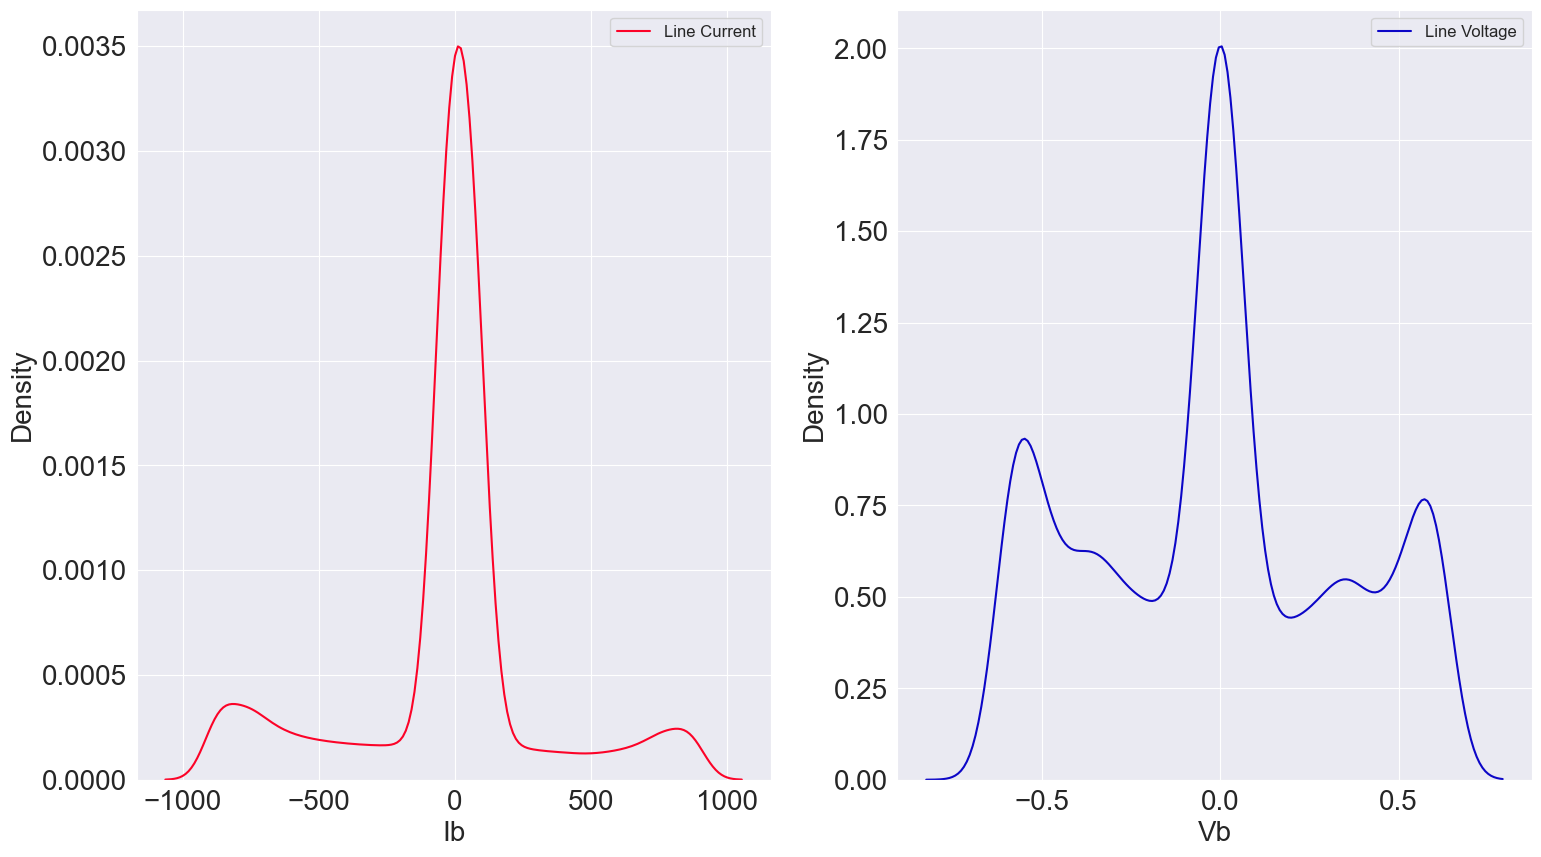

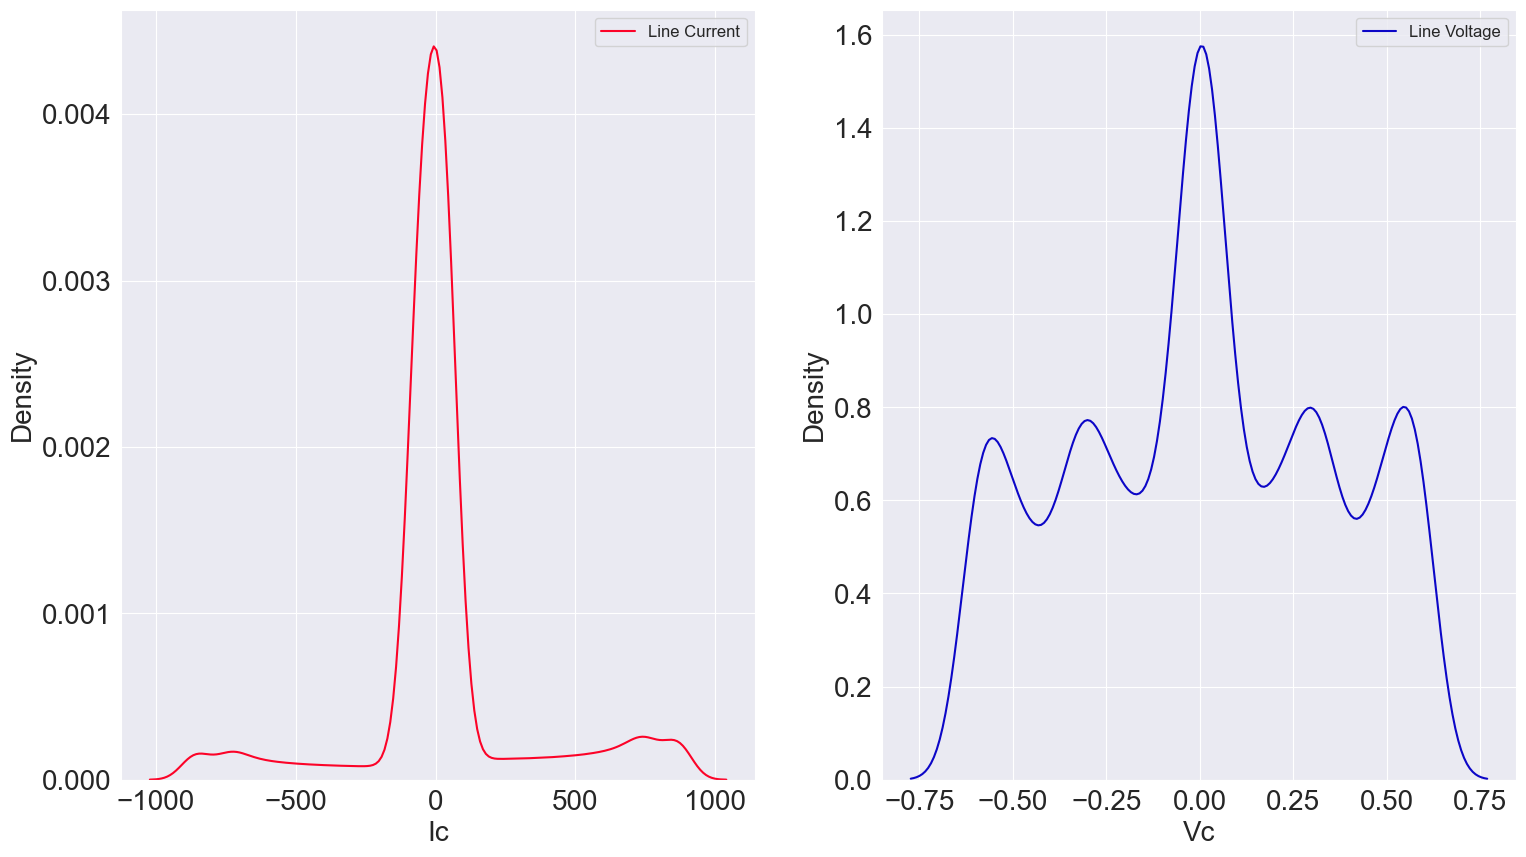

In [24]:
def dist(cola,colb):
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18,10))
    
    sns.distplot(binary_data[cola], label='Line Current', hist=False, color='#fc0328', ax=axs[0])
    sns.distplot(binary_data[colb], label='Line Voltage', hist=False, color='#0c06c7', ax=axs[1])
    
    axs[0].legend(loc='upper right', prop={'size': 12})
    axs[1].legend(loc='upper right', prop={'size': 12})
    
    plt.show()

lines = [
    ('Ia', 'Va'),
    ('Ib', 'Vb'),
    ('Ic', 'Vc')
]

for cola,colb in lines:
    dist(cola,colb)
    print('\n')


# Implementing the SVM model

In [26]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt


class SVMDualProblem:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = 1
            self.degree = degree
        else:
            self.kernel = self._rbf_kernel
            self.sigma = sigma

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

    def _rbf_kernel(self, X1, X2):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1.dot(X2.T)) ** self.degree

    def fit(self, X, y, lr=1e-3, epochs=500):

        self.X = X
        self.y = y

        # (500,)
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        # (500,)
        self.ones = np.ones(X.shape[0])

        # (500,500) =      (500,500) *        (500,500)
        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
            # (500,)  =    (500,)      (500,500).(500,)=(500,)
            gradient = 1 - y_iy_jk_ij.dot(self.alpha)
            # Same code
            # gradient = self.ones - np.sum(y_iy_jk_ij * self.alpha)

            self.alpha = self.alpha + lr * gradient

            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            #                                        (500,500)                            (500,500)
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        # (m,)= (m,)       (n,).(n,m)= (m,)
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        # Alternative code
        # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1)*self.kernel(X, X[index]), axis=0)
        self.b = np.mean(b_i)

        plt.plot(losses)
        plt.title("loss per epochs")
        plt.show()

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')

        plt.show()



# Splitting the data

In [ ]:
y = binary_data.iloc[:,0]
X = binary_data.iloc[:,1:7]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Preprocessing the data

In [27]:
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_test =np.array(X_test)
y_test=np.array(y_test)

# Training the model using polynomial kernel

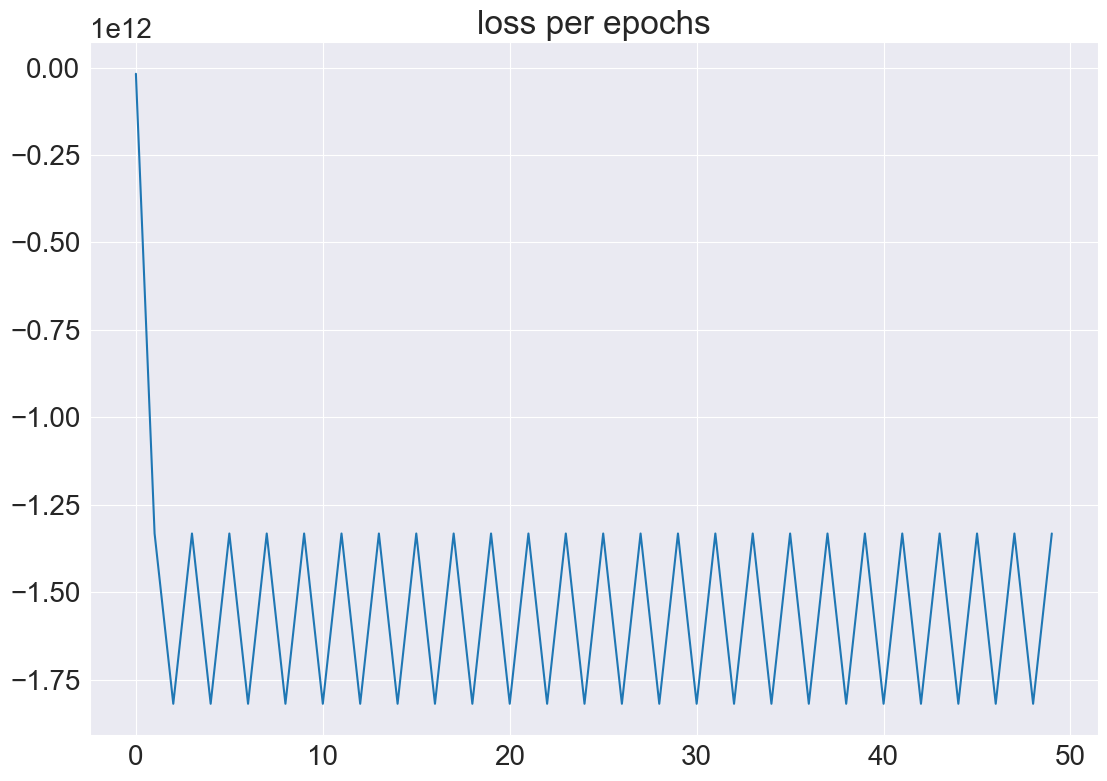

train score: 0.7455555555555555
test score: 0.7470843052315894


In [31]:
S = SVMDualProblem(C=100.0, kernel='poly', degree=2)
S.fit(X_train, y_train, lr=1e-1,epochs=50)
print("train score:", S.score(X_train, y_train))
print("test score:", S.score(X_test, y_test))


# Training the model using RBF kernel

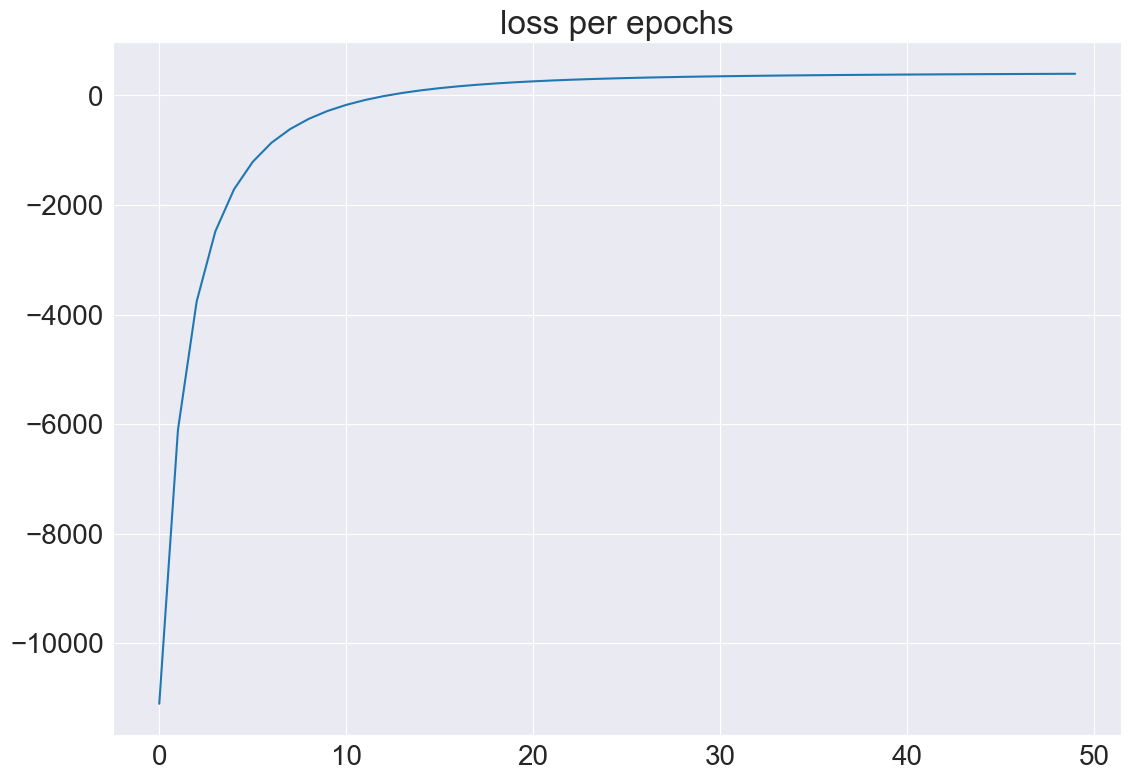

train score: 0.9981111111111111
test score: 0.9943352215928024


In [29]:
S= SVMDualProblem(C=1000, kernel='rbf', sigma=0.1)


S.fit(X_train, y_train, lr=1e-2, epochs=50)
print("train score:", S.score(X_train, y_train))
print("test score:", S.score(X_test, y_test))

# Training the model using scikit learn built in model

In [30]:
# Import necessary libraries
from sklearn import svm
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_test =np.array(X_test)
y_test=np.array(y_test)


# Create a kernel support vector machine model
ksvm = svm.SVC(kernel='rbf',
               gamma=0.1,
               C=10.0)
 
# Train the model on the training data
ksvm.fit(X_train, y_train)
accuracy = ksvm.score(X_train, y_train)
print('Accuracy:', accuracy)
accuracy = ksvm.score(X_test, y_test)
print('Accuracy:', accuracy)



Accuracy: 0.9937777777777778
Accuracy: 0.9950016661112963
